# Project Roadmap

1. Using zipline, get stock returns within 2010~2015
2. PCA for S&P 500 stocks during that period
3. Build risk factor model using stock returns' principal components
4. Cluster stocks then apply different bounds for those stocks (maybe use company specific risks)
5. Backtest with trailing stop, stop-loss & take-profit model
6. Compare performance between different groups

# Import Libraries

In [1]:
import os
import time

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

In [3]:
from zipline.data import bundles
from zipline.pipeline import Pipeline
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import AverageDollarVolume
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader
#from zipline.pipeline.factors import SimpleMovingAverage
from zipline.pipeline.domain import US_EQUITIES

In [4]:
#import warnings
#warnings.filterwarnings("ignore")

# Basic Settings with helper functions

In [5]:
bundle_data = bundles.load('quandl')

In [6]:
# Create a screen for our Pipeline
universe = AverageDollarVolume(window_length = 120).top(300)

In [7]:
# Create an empty Pipeline with the given screen
pipeline = Pipeline(screen = universe, domain=US_EQUITIES)

# Set the dataloader
pricing_loader = USEquityPricingLoader(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader, fx_reader='United States')

In [8]:
# Define the function for the get_loader parameter
def choose_loader(column):
    if column not in USEquityPricing.columns:
        raise Exception('Column not in USEquityPricing')
    return pricing_loader

# Set the trading calendar
trading_calendar = get_calendar('NYSE')

# Create a Pipeline engine
engine = SimplePipelineEngine(get_loader = choose_loader,
                              asset_finder = bundle_data.asset_finder)

In [9]:
# Set the start and end dates
start_date = pd.Timestamp('2011-01-06', tz = 'utc')
end_date = pd.Timestamp('2013-01-07', tz = 'utc')

In [10]:
# Run our pipeline for the given start and end dates
pipeline_output = engine.run_pipeline(pipeline, end_date, end_date)

In [11]:
# Get the values in index level 1 and save them to a list
universe_tickers = pipeline_output.index.get_level_values(1).values.tolist()

# Create a data portal
data_portal = DataPortal(bundle_data.asset_finder,
                         trading_calendar = trading_calendar,
                         first_trading_day = bundle_data.equity_daily_bar_reader.first_trading_day,
                         equity_daily_reader = bundle_data.equity_daily_bar_reader,
                         adjustment_reader = bundle_data.adjustment_reader)

In [12]:
def get_pricing(data_portal, trading_calendar, assets, start_d, end_d, field='close'):
    
    # Set the given start and end dates to Timestamps. The frequency string C is used to
    # indicate that a CustomBusinessDay DateOffset is used
    start_dt = pd.Timestamp(start_d, freq='C').tz_convert('UTC')
    end_dt = pd.Timestamp(end_d, freq='C').tz_convert('UTC')
    
    """
    end_dt = pd.Timestamp(end_d, tz='UTC', freq='C')
    start_dt = pd.Timestamp(start_d, tz='UTC', freq='C')
    """
    
    # Get the locations of the start and end dates
    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    # return the historical data for the given window
    return data_portal.get_history_window(assets=assets, end_dt=end_dt, bar_count=end_loc - start_loc,
                                          frequency='1d',
                                          field=field,
                                          data_frequency='daily')



def get_returns(start_date='2011-01-05', end_date='2016-01-05'):
    
    # Get the historical data for the given window
    historical_data = get_pricing(data_portal, trading_calendar, universe_tickers,
                                  start_d=start_date, end_d=end_date)
    
    return historical_data.pct_change()[1:].fillna(0)

In [13]:
returns = get_returns(start_date, end_date)

In [14]:
returns

,Equity(0 [A]),Equity(2 [AAL]),Equity(8 [AAPL]),Equity(13 [ABC]),Equity(20 [ABT]),Equity(27 [ACE]),Equity(37 [ACN]),Equity(45 [ADBE]),Equity(49 [ADM]),Equity(52 [ADP]),...,Equity(3099 [WM]),Equity(3101 [WMB]),Equity(3105 [WMT]),Equity(3136 [WU]),Equity(3142 [WY]),Equity(3144 [WYNN]),Equity(3145 [X]),Equity(3156 [XOM]),Equity(3172 [YHOO]),Equity(3175 [YUM])
2011-01-10 00:00:00+00:00,0.014415,0.006140,0.018850,-0.005739,-0.008889,-0.013062,-0.008855,0.028714,0.004390,0.000419,...,-0.001649,-0.006848,-0.006463,-0.008818,0.011171,-0.000251,-0.013176,-0.006082,-0.017868,0.001406
2011-01-11 00:00:00+00:00,0.017057,-0.043592,-0.002380,0.009798,-0.002088,0.004620,0.013704,0.000607,0.003718,0.004581,...,-0.003033,0.025055,0.010423,0.011532,0.015884,-0.013560,0.030326,0.007447,-0.001205,-0.006456
2011-01-12 00:00:00+00:00,0.004422,-0.008204,0.008136,-0.005980,0.003804,0.001815,0.022974,0.017950,0.010887,0.013067,...,0.008856,0.020489,0.010315,-0.004669,0.019846,-0.002650,-0.007900,0.011760,0.004222,0.002658
2011-01-13 00:00:00+00:00,-0.003700,0.000919,0.003659,0.014921,-0.004453,0.000328,-0.000397,-0.005719,0.020574,-0.009631,...,0.008808,0.024355,-0.001094,-0.002073,-0.009730,-0.000510,-0.018180,0.001700,0.006006,-0.005092
2011-01-14 00:00:00+00:00,0.006746,-0.009183,0.008102,0.001395,-0.010088,-0.001311,0.002594,0.012283,0.008410,0.004939,...,0.009560,-0.002260,0.000365,0.007816,0.013597,0.017988,-0.016731,0.014724,0.003582,-0.021678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 00:00:00+00:00,0.027868,0.055512,0.044318,0.008407,0.016742,0.010510,0.012793,0.021138,0.012195,0.010652,...,0.008368,0.029884,0.009170,0.017190,0.008702,0.025714,0.035606,0.017039,0.020513,0.025958
2013-01-02 00:00:00+00:00,0.022960,0.035556,0.031676,0.007179,0.038898,0.024937,0.038496,0.017516,0.046732,0.025646,...,0.006817,0.039401,0.014803,0.011021,0.047807,0.049604,0.085535,0.024957,0.009045,0.011446
2013-01-03 00:00:00+00:00,0.003582,-0.022890,-0.012630,-0.002069,0.038066,0.005257,-0.003620,-0.015389,-0.008022,0.003939,...,0.003533,-0.007640,-0.006355,-0.016715,0.000000,0.010756,-0.018154,-0.001804,-0.014940,0.006254
2013-01-04 00:00:00+00:00,0.019748,0.078331,-0.027847,0.006682,-0.006011,0.001216,0.005522,0.010066,0.027426,0.008837,...,-0.000293,0.010956,0.003779,0.036216,0.008233,0.012066,0.011015,0.004630,0.004044,0.010950


# Risk Factor Model

## Fit PCA

In [15]:
from sklearn.decomposition import PCA

In [16]:
def fit_pca(returns, n_components, svd_solver):
    """
    Fit PCA model with returns.

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    n_components : int or float
        Number of factors for PCA or probability explained by principal components
    svd_solver: str
        The solver to use for the PCA model

    Returns
    -------
    pca : PCA
        Model fit to returns
    """
    pca = PCA(n_components=n_components, svd_solver=svd_solver)
    pca.fit(returns)
    
    return pca

In [17]:
pca = fit_pca(returns, 0.9, 'full')

### View Data

In [18]:
pca.components_

array([[-0.08330925, -0.06869394, -0.04124278, ..., -0.04336103,
        -0.04569926, -0.03903397],
       [-0.00838058, -0.17747155,  0.02791607, ..., -0.01682482,
         0.00422776, -0.01744134],
       [ 0.01307611,  0.1360883 ,  0.05984691, ..., -0.04066171,
         0.02310387,  0.06313658],
       ...,
       [-0.05439067, -0.0936153 ,  0.01986447, ..., -0.02943649,
        -0.05517094, -0.06339785],
       [-0.05358196,  0.08594167,  0.06726434, ..., -0.00740358,
        -0.06519302, -0.01773719],
       [ 0.0369583 ,  0.03054647, -0.08526682, ...,  0.00622322,
         0.03751485,  0.04045898]])

In [ ]:
n_components = pca.components_.shape[0]

<BarContainer object of 94 artists>

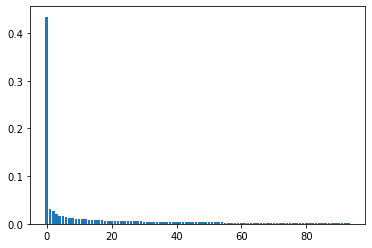

In [20]:
plt.bar(np.arange(n_components), pca.explained_variance_ratio_)

## Factor Betas

In [21]:
def factor_betas(pca, factor_beta_indices, factor_beta_columns):
    """
    Get the factor betas from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    factor_beta_indices : 1 dimensional Ndarray
        Factor beta indices
    factor_beta_columns : 1 dimensional Ndarray
        Factor beta columns

    Returns
    -------
    factor_betas : DataFrame
        Factor betas
    """
    assert len(factor_beta_indices.shape) == 1
    assert len(factor_beta_columns.shape) == 1
    
    factor_betas = pd.DataFrame(pca.components_.T, index=factor_beta_indices, columns=factor_beta_columns)
    
    return factor_betas

In [22]:
risk_model = {}
risk_model['factor_betas'] = factor_betas(pca, returns.columns.values, np.arange(n_components))

In [23]:
risk_model['factor_betas'].head()

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
Equity(0 [A]),-0.083309,-0.008381,0.013076,-0.002633,0.026477,0.003597,-0.012678,-0.035716,0.002795,0.005720,...,-0.044466,0.089199,0.024311,0.142815,0.069553,-0.106583,-0.044436,-0.054391,-0.053582,0.036958
Equity(2 [AAL]),-0.068694,-0.177472,0.136088,0.277813,0.072751,-0.284165,0.160130,0.049194,0.287037,0.046559,...,-0.024704,-0.024877,-0.000367,0.013660,0.015205,0.037239,0.102870,-0.093615,0.085942,0.030546
Equity(8 [AAPL]),-0.041243,0.027916,0.059847,-0.032275,0.003960,-0.013115,0.031659,-0.000336,0.003114,-0.061251,...,-0.035768,0.105882,-0.106181,-0.128505,-0.040861,-0.119150,0.046547,0.019864,0.067264,-0.085267
Equity(13 [ABC]),-0.034558,-0.015387,0.011445,-0.029748,-0.004631,-0.010814,0.015163,-0.025669,-0.010966,0.021284,...,-0.027982,-0.039385,-0.047841,-0.061294,0.049857,-0.101992,0.051355,-0.033508,-0.030381,0.020689
Equity(20 [ABT]),-0.024255,-0.045449,0.007961,-0.017569,-0.020429,0.013873,-0.003232,-0.032699,-0.013597,0.009782,...,-0.026308,0.009377,-0.017540,-0.045725,-0.020814,0.004902,0.024529,0.026691,0.010813,0.028894


## Factor Returns

In [24]:
def factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    """
    Get the factor returns from the PCA model.

    Parameters
    ----------
    pca : PCA
        Model fit to returns
    returns : DataFrame
        Returns for each ticker and date
    factor_return_indices : 1 dimensional Ndarray
        Factor return indices
    factor_return_columns : 1 dimensional Ndarray
        Factor return columns

    Returns
    -------
    factor_returns : DataFrame
        Factor returns
    """
    assert len(factor_return_indices.shape) == 1
    assert len(factor_return_columns.shape) == 1
    
    factor_returns = pd.DataFrame(pca.transform(returns), index=factor_return_indices, columns=factor_return_columns)
    
    return factor_returns

In [25]:
risk_model['factor_returns'] = factor_returns(pca, returns, returns.index, np.arange(n_components))

<AxesSubplot:>

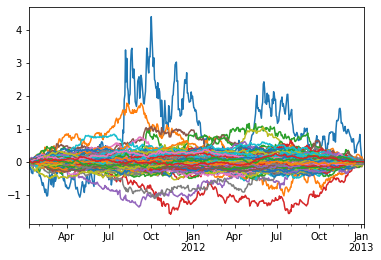

In [26]:
risk_model['factor_returns'].cumsum().plot(legend=None)

In [412]:
risk_model['factor_returns'].head()

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
2011-01-10 00:00:00+00:00,0.006458,0.058455,0.033410,-0.022177,0.031756,-0.019893,-0.009014,-0.058141,-0.026837,0.025801,...,0.000658,0.010119,0.009517,-0.009656,0.008585,-0.011795,0.000195,-0.022678,0.015686,0.017343
2011-01-11 00:00:00+00:00,-0.085693,0.025431,-0.109053,-0.020033,0.014663,0.012230,0.003799,0.007578,0.002034,-0.067596,...,0.006973,-0.010899,0.010608,0.001657,-0.007289,0.011984,-0.002141,-0.018787,-0.001428,-0.002786
2011-01-12 00:00:00+00:00,-0.133752,0.004290,-0.025783,0.020204,0.051511,0.035311,-0.016596,-0.007813,-0.035234,-0.023893,...,0.016330,0.022749,-0.019499,-0.003652,-0.004940,-0.005363,-0.005788,0.028071,-0.008728,0.012369
2011-01-13 00:00:00+00:00,0.019280,0.019536,0.029307,-0.006450,0.018794,-0.009566,0.010025,0.002732,-0.018979,-0.002084,...,0.011511,-0.036536,0.001585,-0.035012,-0.017325,-0.004421,-0.013661,0.002156,-0.016895,-0.019771
2011-01-14 00:00:00+00:00,-0.131170,-0.044423,0.046050,-0.033573,0.016471,0.030591,-0.051052,0.026275,-0.052395,-0.061370,...,-0.005525,-0.005685,0.031470,-0.015066,-0.029907,-0.012073,-0.004197,-0.012616,-0.019545,-0.017629


## Factor Covariance Matrix

In [27]:
def factor_cov_matrix(factor_returns, ann_factor):
    """
    Get the factor covariance matrix

    Parameters
    ----------
    factor_returns : DataFrame
        Factor returns
    ann_factor : int
        Annualization factor

    Returns
    -------
    factor_cov_matrix : 2 dimensional Ndarray
        Factor covariance matrix
    """
    
    factor_cov_matrix = np.diag(np.var(factor_returns, axis=0, ddof=1)*ann_factor)
    
    return factor_cov_matrix

In [28]:
ann_factor = 252 # number of trading days
risk_model['factor_cov_matrix'] = factor_cov_matrix(risk_model['factor_returns'], ann_factor)

## Idiosyncratic Variance Matrix

In [29]:
def idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    """
    Get the idiosyncratic variance matrix

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    factor_returns : DataFrame
        Factor returns
    factor_betas : DataFrame
        Factor betas
    ann_factor : int
        Annualization factor

    Returns
    -------
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix
    """
    
    _common_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    _residuals = (returns - _common_returns)
    idiosyncratic_var_matrix = pd.DataFrame(np.diag(np.var(_residuals)*ann_factor), returns.columns, returns.columns)
    
    return idiosyncratic_var_matrix

In [30]:
risk_model['idiosyncratic_var_matrix'] = idiosyncratic_var_matrix(returns, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)

In [31]:
risk_model['idiosyncratic_var_matrix'].head()

,Equity(0 [A]),Equity(2 [AAL]),Equity(8 [AAPL]),Equity(13 [ABC]),Equity(20 [ABT]),Equity(27 [ACE]),Equity(37 [ACN]),Equity(45 [ADBE]),Equity(49 [ADM]),Equity(52 [ADP]),...,Equity(3099 [WM]),Equity(3101 [WMB]),Equity(3105 [WMT]),Equity(3136 [WU]),Equity(3142 [WY]),Equity(3144 [WYNN]),Equity(3145 [X]),Equity(3156 [XOM]),Equity(3172 [YHOO]),Equity(3175 [YUM])
Equity(0 [A]),0.016176,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Equity(2 [AAL]),0.000000,0.005112,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Equity(8 [AAPL]),0.000000,0.000000,0.015889,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Equity(13 [ABC]),0.000000,0.000000,0.000000,0.01422,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Equity(20 [ABT]),0.000000,0.000000,0.000000,0.00000,0.008815,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Idiosyncratic Variance Vector 

In [35]:
def idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    """
    Get the idiosyncratic variance vector

    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    idiosyncratic_var_matrix : DataFrame
        Idiosyncratic variance matrix

    Returns
    -------
    idiosyncratic_var_vector : DataFrame
        Idiosyncratic variance Vector
    """
    
    idiosyncratic_var_vector = pd.DataFrame(np.diag(idiosyncratic_var_matrix), returns.columns)
    
    return idiosyncratic_var_vector

In [36]:
idiosyncratic_var_vector = idiosyncratic_var_vector(returns, risk_model['idiosyncratic_var_matrix'])

In [37]:
idiosyncratic_var_vector

,0
Equity(0 [A]),0.016176
Equity(2 [AAL]),0.005112
Equity(8 [AAPL]),0.015889
Equity(13 [ABC]),0.014220
Equity(20 [ABT]),0.008815
...,...
Equity(3144 [WYNN]),0.013671
Equity(3145 [X]),0.010745
Equity(3156 [XOM]),0.005764
Equity(3172 [YHOO]),0.011832


# Sort & Cluster

In [44]:
low_var_equities_df = idiosyncratic_var_vector.sort_values(by=[0]).iloc[:100]
mid_var_equities_df = idiosyncratic_var_vector.sort_values(by=[0]).iloc[100:200]
high_var_equities_df = idiosyncratic_var_vector.sort_values(by=[0]).iloc[200:]

In [69]:
low_var_equities_tickers = list(low_var_equities_df.index)
mid_var_equities_tickers = list(mid_var_equities_df.index)
high_var_equities_tickers = list(high_var_equities_df.index)

In [70]:
def extract_ticker(equity):
    return str(equity).split('[')[1].split(']')[0]

In [71]:
extract_ticker(high_var_equities_tickers[4])

'FITB'

# Backtest (Cluster-wise)

## Set benchmark

In [130]:
from zipline import run_algorithm
from zipline.api import order, record, symbol, order_target, order_percent

In [238]:
sp500 = web.DataReader('^GSPC', 'yahoo', start_date, end_date)['Adj Close']

In [239]:
sp500

Date
2011-01-05    1276.560059
2011-01-06    1273.849976
2011-01-07    1271.500000
2011-01-10    1269.750000
2011-01-11    1274.479980
                 ...     
2012-12-31    1426.189941
2013-01-02    1462.420044
2013-01-03    1459.369995
2013-01-04    1466.469971
2013-01-07    1461.890015
Name: Adj Close, Length: 504, dtype: float64

In [240]:
benchmark_returns = sp500.pct_change()

In [241]:
market_risk = benchmark_returns.std()

In [242]:
market_risk

0.011859278187094723

In [116]:
high_var_equities_df

,0
Equity(814 [DG]),0.013888
Equity(1402 [HST]),0.013951
Equity(2143 [OXY]),0.014019
Equity(2813 [TMO]),0.014061
Equity(1088 [FITB]),0.014088
...,...
Equity(162 [AMT]),0.018853
Equity(529 [CELG]),0.019037
Equity(514 [CCL]),0.019405
Equity(2314 [PSX]),0.020160


## Dictionary to save results

In [151]:
results = {}

## Buy and Hold

Buy 10 shares at the beginning at hold until the end

In [157]:
def buy_and_hold(stocks):
    bnh_results = {}
    
    for stock in stocks:
        
        selected_stock = extract_ticker(stock)
        
        def initialize(context):
            context.has_ordered = False
            
        def handle_data(context, data):
            # record price for further inspection
            record(price=data.current(symbol(selected_stock), 'price'))

            # trading logic
            if not context.has_ordered:
                # All in
                order_percent(symbol(selected_stock), 1.0)
                # setting up a flag for holding a position
                context.has_ordered = True
        try:        
            result = run_algorithm(
                start=start_date,
                end=end_date,
                initialize=initialize,
                handle_data=handle_data,
                capital_base=100000,
                benchmark_returns=benchmark_returns,
                bundle='quandl',
                data_frequency='daily'
            )
        except:
            pass
        
        bnh_results[stock] = result
        
    return bnh_results

In [158]:
bnh_high = buy_and_hold(high_var_equities_tickers)

In [204]:
np.mean([bnh_high[stock].portfolio_value.iloc[-1] for stock in list(bnh_high.keys())])

121052.283082465

In [159]:
bnh_mid = buy_and_hold(mid_var_equities_tickers)

In [205]:
np.mean([bnh_mid[stock].portfolio_value.iloc[-1] for stock in list(bnh_mid.keys())])

116584.97531780999

In [160]:
bnh_low = buy_and_hold(low_var_equities_tickers)

In [206]:
np.mean([bnh_low[stock].portfolio_value.iloc[-1] for stock in list(bnh_low.keys())])

122566.64990998

## Moving Average Based Strategy

In [181]:
from zipline.api import order_target_percent

In [182]:
def moving_average(stocks):
    ma_results = {}
    
    for stock in stocks:
        
        selected_stock = extract_ticker(stock)
        
        def initialize_ma(context):
            context.i = 0
            context.sym = symbol(selected_stock)
            context.hold = False

        def handle_data_ma(context, data):
            context.i += 1
            if context.i < 20:
                return

            buy = False
            sell = False

            ma5 = data.history(context.sym, 'price', 5, '1d').mean()
            ma20 = data.history(context.sym, 'price', 20, '1d').mean()

            if ma5 > ma20 and context.hold == False:
                order_target_percent(context.sym, 1.0)
                context.hold = True
                buy = True
                
            elif ma5 < ma20 and context.hold == True:
                order_target_percent(context.sym, 0.0)
                context.hold = False
                sell = True

            record(PRICE=data.current(context.sym, "price"), ma5=ma5, ma20=ma20, buy=buy, sell=sell)
        try:
            ma_result = run_algorithm(start=start_date,
                                      end=end_date,
                                      initialize=initialize_ma,
                                      handle_data=handle_data_ma,
                                      capital_base=100000,
                                      benchmark_returns=benchmark_returns,
                                      bundle='quandl',
                                      data_frequency='daily'
                                     )
            
            ma_results[stock] = ma_result
        except:
            pass
        
        
        
    return ma_results

In [183]:
ma_high = moving_average(high_var_equities_tickers)

In [202]:
np.mean([ma_high[stock].portfolio_value.iloc[-1] for stock in list(ma_high.keys())])

101566.89459850999

In [184]:
ma_mid = moving_average(mid_var_equities_tickers)

In [203]:
np.mean([ma_mid[stock].portfolio_value.iloc[-1] for stock in list(ma_mid.keys())])

99030.16738984

In [188]:
ma_low = moving_average(low_var_equities_tickers)

In [201]:
np.mean([ma_low[stock].portfolio_value.iloc[-1] for stock in list(ma_low.keys())])

102133.81963112499

## Invest in S&P 500

In [129]:
sp500.iloc[-1]/sp500.iloc[0] - 1

0.18230931603678213

## Stop-loss and Take-profit

In [391]:
def sl_tp(stocks):
    
    sl_result = {}
    
    for stock in stocks:
        
        def initialize_sl(context):
            context.i = 0
            context.sym = symbol(extract_ticker(stock))
            context.hold = False
            
        def handle_data_sl(context, data):
            context.i += 1
            
            record(ORDERED=context.hold)
            if context.i == 1:
                order_target_percent(context.sym, 1.0)
                context.hold = True
                return
            elif context.i < 5:
                return
            
            ma5 = data.history(context.sym, 'price', 5, '1d').pct_change().mean()
            st5 = data.history(context.sym, 'price', 5, '1d').pct_change().std()

            if context.hold == True and abs(ma5) > 0.03 and st5 > market_risk + idiosyncratic_var_vector.loc[selected_stock].values[0]:
                order_target_percent(context.sym, 0.0)
                context.hold = False
        try:
            bt_result = run_algorithm(start=start_date, 
                                      end=end_date,
                                      initialize=initialize_sl,
                                      handle_data=handle_data_sl,
                                      capital_base=100000,
                                      benchmark_returns=benchmark_returns,
                                      bundle='quandl',
                                      data_frequency='daily'
                                     )
            sl_result[stock] = bt_result
        except:
            pass
    return sl_result
            

### Risk

In [392]:
sl_tp_high_10 = sl_tp(high_var_equities_tickers)

In [393]:
np.mean([sl_tp_high_10[stock].portfolio_value.iloc[-1] for stock in list(sl_tp_high_10.keys())])

102164.22002968367

In [394]:
sl_tp_mid_10 = sl_tp(mid_var_equities_tickers)

In [395]:
np.mean([sl_tp_mid_10[stock].portfolio_value.iloc[-1] for stock in list(sl_tp_mid_10.keys())])

102432.47151367173

In [396]:
sl_tp_low_10 = sl_tp(low_var_equities_tickers)

In [397]:
np.mean([sl_tp_low_10[stock].portfolio_value.iloc[-1] for stock in list(sl_tp_low_10.keys())])

109101.50334042187

In [410]:
np.mean([bnh_high[stock].portfolio_value.iloc[-1] for stock in bnh_high if bnh_high[stock].portfolio_value.iloc[-1] > 100000])

137243.71454789286

In [411]:
np.mean([sl_tp_high_10[stock].portfolio_value.iloc[-1] for stock in sl_tp_high_10 if sl_tp_high_10[stock].portfolio_value.iloc[-1] > 100000])

126496.28346262196

In [423]:
for stock in bnh_high.keys():
    if bnh_high[stock].portfolio_value.iloc[-1] < 100000:
        print(stock, bnh_high[stock].portfolio_value.iloc[-1])

Equity(1402 [HST]) 92030.66503999999
Equity(2143 [OXY]) 83051.97758
Equity(138 [AMAT]) 83456.84198
Equity(878 [DVN]) 69455.50605999999
Equity(421 [BRCM]) 76592.28132400001
Equity(3012 [VOD]) 96354.71257999999
Equity(216 [ARNC]) 55203.86848
Equity(1575 [JOY]) 77749.97027500001
Equity(300 [BAC]) 84985.734375
Equity(457 [C]) 85931.30905999999
Equity(729 [CTL]) 89652.509
Equity(1631 [KSS]) 80942.3977
Equity(2675 [STJ]) 92290.80094999999
Equity(1720 [LRCX]) 79590.17559999999
Equity(412 [BP]) 94151.16148
Equity(1031 [F]) 73382.45912
Equity(440 [BTU]) 43548.75719499999
Equity(1331 [HES]) 70506.32173
Equity(994 [ESRX]) 96896.95474999999
Equity(1917 [MUR]) 85316.69124999999
Equity(1378 [HOT]) 97253.873715
Equity(705 [CSCO]) 96699.54209500001
Equity(2517 [SCHW]) 85366.98602
Equity(49 [ADM]) 87515.743875
Equity(134 [ALTR]) 97388.07680000001
Equity(3006 [VMW]) 97020.956485
Equity(608 [CME]) 87163.98405999999
Equity(1884 [MRO]) 81917.962415
Equity(514 [CCL]) 78375.03444999999
Equity(2314 [PSX]) 783

In [424]:
for stock in sl_tp_high_10.keys():
    if sl_tp_high_10[stock].portfolio_value.iloc[-1] < 100000:
        print(stock, sl_tp_high_10[stock].portfolio_value.iloc[-1])

Equity(1402 [HST]) 74195.20367
Equity(2813 [TMO]) 98660.57865999997
Equity(1088 [FITB]) 71689.19011249999
Equity(138 [AMAT]) 75492.696265
Equity(878 [DVN]) 87468.44958999999
Equity(421 [BRCM]) 78289.45306899998
Equity(3012 [VOD]) 96354.71257999999
Equity(642 [COH]) 94925.473135
Equity(216 [ARNC]) 77711.95024000002
Equity(2220 [PH]) 78432.44769999999
Equity(1575 [JOY]) 92244.31937500002
Equity(2726 [SYMC]) 96274.03203999998
Equity(851 [DOV]) 93976.63115500002
Equity(300 [BAC]) 46314.76849999999
Equity(472 [CAM]) 98278.25603500001
Equity(1516 [IR]) 68515.98009999999
Equity(736 [CTSH]) 86360.1851
Equity(457 [C]) 56570.65956
Equity(729 [CTL]) 75863.04100000001
Equity(963 [EOG]) 77785.80876999999
Equity(828 [DISCA]) 97862.4632
Equity(997 [ESV]) 87317.25159999997
Equity(1498 [INTU]) 92095.69464999998
Equity(2883 [TWC]) 95302.91556000001
Equity(1631 [KSS]) 91096.8376
Equity(1651 [LBTYA]) 97202.05506
Equity(2675 [STJ]) 93374.20405
Equity(1720 [LRCX]) 89415.79391999998
Equity(412 [BP]) 94151.16

### 0.5 Risk

### 1.5 Risk

In [374]:
selected_stock = high_var_equities_tickers[3]

def initialize_sl(context):
    context.i = 0
    context.sym = symbol(extract_ticker(selected_stock))
    context.hold = False

def handle_data_sl(context, data):
    
    context.i += 1
    
    record(ORDERED=context.hold)
    if context.i == 1:
        order_target_percent(context.sym, 1.0)
        context.hold = True
        return

    ma5 = data.history(context.sym, 'price', 5, '1d').pct_change().mean()
    st5 = data.history(context.sym, 'price', 5, '1d').pct_change().std()
    
    if context.hold == True and abs(ma5) > 0.03 and st5 > market_risk + idiosyncratic_var_vector.loc[selected_stock].values[0]:
        order_target_percent(context.sym, 0.0)
        context.hold = False
    

sl_result = run_algorithm(start=start_date,
                          end=end_date,
                          initialize=initialize_sl,
                          handle_data=handle_data_sl,
                          capital_base=100000,
                          benchmark_returns=benchmark_returns,
                          bundle='quandl',
                          data_frequency='daily'
                         )

In [375]:
sl_result.portfolio_value

2011-01-06 21:00:00+00:00    100000.000000
2011-01-07 21:00:00+00:00     99948.430105
2011-01-10 21:00:00+00:00     99542.020105
2011-01-11 21:00:00+00:00     99400.660105
2011-01-12 21:00:00+00:00    100425.520105
                                 ...      
2012-12-31 21:00:00+00:00     98660.578660
2013-01-02 21:00:00+00:00     98660.578660
2013-01-03 21:00:00+00:00     98660.578660
2013-01-04 21:00:00+00:00     98660.578660
2013-01-07 21:00:00+00:00     98660.578660
Name: portfolio_value, Length: 503, dtype: float64

In [350]:
sl_result.loc[sl_result.ORDERED==False].index

DatetimeIndex(['2011-01-06 21:00:00+00:00', '2011-05-02 20:00:00+00:00',
               '2011-05-03 20:00:00+00:00', '2011-05-04 20:00:00+00:00',
               '2011-05-05 20:00:00+00:00', '2011-05-06 20:00:00+00:00',
               '2011-05-09 20:00:00+00:00', '2011-05-10 20:00:00+00:00',
               '2011-05-11 20:00:00+00:00', '2011-05-12 20:00:00+00:00',
               ...
               '2012-12-21 21:00:00+00:00', '2012-12-24 18:00:00+00:00',
               '2012-12-26 21:00:00+00:00', '2012-12-27 21:00:00+00:00',
               '2012-12-28 21:00:00+00:00', '2012-12-31 21:00:00+00:00',
               '2013-01-02 21:00:00+00:00', '2013-01-03 21:00:00+00:00',
               '2013-01-04 21:00:00+00:00', '2013-01-07 21:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=425, freq=None)

In [353]:
sl_result.loc['2011-05-02 20:00:00+00:00']

period_open                                        2011-05-02 13:31:00+00:00
period_close                                       2011-05-02 20:00:00+00:00
ending_value                                                             0.0
starting_cash                                                      296.29758
ending_cash                                                     120141.94826
portfolio_value                                                 120141.94826
returns                                                             0.012142
longs_count                                                                0
shorts_count                                                               0
long_value                                                               0.0
short_value                                                              0.0
pnl                                                               1441.21068
capital_used                                                    119845.65068

In [263]:
idiosyncratic_var_vector.loc[high_var_equities_tickers[2]].values[0]

0.014018886028945665

In [290]:
abs(np.mean([-0.03, -0.05, 0.05, 0.01, -.02]))

0.007999999999999998

In [288]:
high_var_equities_tickers[2]

Equity(2143 [OXY])

In [298]:
bnh_high[selected_stock].portfolio_value.

2011-01-06 21:00:00+00:00    100000.00000
2011-01-07 21:00:00+00:00     99949.13758
2011-01-10 21:00:00+00:00     99534.73758
2011-01-11 21:00:00+00:00    100705.41758
2011-01-12 21:00:00+00:00    101306.29758
                                 ...     
2012-12-31 21:00:00+00:00     79664.25758
2013-01-02 21:00:00+00:00     81270.05758
2013-01-03 21:00:00+00:00     81591.21758
2013-01-04 21:00:00+00:00     83010.53758
2013-01-07 21:00:00+00:00     83051.97758
Name: portfolio_value, Length: 503, dtype: float64

In [341]:
sl_result.portfolio_value

2011-01-06 21:00:00+00:00    100000.000000
2011-01-07 21:00:00+00:00     99946.443875
2011-01-10 21:00:00+00:00    100388.143875
2011-01-11 21:00:00+00:00    100766.743875
2011-01-12 21:00:00+00:00    101870.993875
                                 ...      
2012-12-31 21:00:00+00:00     85559.643875
2013-01-02 21:00:00+00:00     89598.043875
2013-01-03 21:00:00+00:00     88872.393875
2013-01-04 21:00:00+00:00     91333.293875
2013-01-07 21:00:00+00:00     87515.743875
Name: portfolio_value, Length: 503, dtype: float64

In [365]:
selected_stock = high_var_equities_tickers[2]

def initialize_sl(context):
    context.i = 0
    context.sym = symbol(extract_ticker(selected_stock))
    context.hold = False

def handle_data_sl(context, data):
    
    context.i += 1
    
    record(ORDERED=context.hold)
    if context.i == 1:
        order_target_percent(context.sym, 1.0)
        context.hold = True
        return
    elif context.i < 5:
        return

    ma5 = data.history(context.sym, 'price', 5, '1d').pct_change().mean()
    st5 = data.history(context.sym, 'price', 5, '1d').pct_change().std()
    
    if context.hold == True and abs(ma5) > 0.03 and st5 > market_risk + idiosyncratic_var_vector.loc[selected_stock].values[0]:
        order_target_percent(context.sym, 0.0)
        context.hold = False
    

sl_result = run_algorithm(start=start_date,
                          end=end_date,
                          initialize=initialize_sl,
                          handle_data=handle_data_sl,
                          capital_base=100000,
                          benchmark_returns=benchmark_returns,
                          bundle='quandl',
                          data_frequency='daily'
                         )

In [366]:
sl_result.portfolio_value

2011-01-06 21:00:00+00:00    100000.00000
2011-01-07 21:00:00+00:00     99949.13758
2011-01-10 21:00:00+00:00     99534.73758
2011-01-11 21:00:00+00:00    100705.41758
2011-01-12 21:00:00+00:00    101306.29758
                                 ...     
2012-12-31 21:00:00+00:00    120141.94826
2013-01-02 21:00:00+00:00    120141.94826
2013-01-03 21:00:00+00:00    120141.94826
2013-01-04 21:00:00+00:00    120141.94826
2013-01-07 21:00:00+00:00    120141.94826
Name: portfolio_value, Length: 503, dtype: float64

In [420]:
print(list(map(extract_ticker, high_var_equities_tickers[:5])))

['DG', 'HST', 'OXY', 'TMO', 'FITB']


In [421]:
print(list(map(extract_ticker, mid_var_equities_tickers[:5])))

['AXP', 'MS', 'DAL', 'ACE', 'SNDK']


In [422]:
print(list(map(extract_ticker, low_var_equities_tickers[:5])))

['QCOR', 'GMCR', 'FSLR', 'NFLX', 'TMUS']


In [441]:
bnh_high[high_var_equities_tickers[3]].sharpe

2011-01-06 21:00:00+00:00          NaN
2011-01-07 21:00:00+00:00   -11.224972
2011-01-10 21:00:00+00:00   -10.951720
2011-01-11 21:00:00+00:00   -13.171922
2011-01-12 21:00:00+00:00     2.482855
                               ...    
2012-12-31 21:00:00+00:00     0.361706
2013-01-02 21:00:00+00:00     0.395469
2013-01-03 21:00:00+00:00     0.389509
2013-01-04 21:00:00+00:00     0.404880
2013-01-07 21:00:00+00:00     0.418445
Name: sharpe, Length: 503, dtype: float64

# Results

In [430]:
np.mean([ma_high[stock].max_drawdown.iloc[-1] for stock in high_var_equities_tickers])

-0.2707056697463051

In [431]:
np.mean([bnh_high[stock].max_drawdown.iloc[-1] for stock in high_var_equities_tickers])

-0.3432296489262172

In [433]:
np.mean([sl_tp_high_10[stock].max_drawdown.iloc[-1] for stock in list(sl_tp_high_10.keys())])

-0.2545149186229568

In [442]:
np.mean([bnh_high[stock].portfolio_value.iloc[-1] for stock in high_var_equities_tickers])

121052.283082465

In [444]:
np.mean([ma_high[stock].portfolio_value.iloc[-1] for stock in high_var_equities_tickers])

101566.89459850999

In [437]:
np.mean([sl_tp_high_10[stock].sharpe[-1] for stock in list(sl_tp_high_10.keys())])

0.06426282298609001

In [438]:
np.mean([bnh_high[stock].sharpe.iloc[-1] for stock in high_var_equities_tickers])

0.43513634960734643

In [439]:
np.mean([ma_high[stock].sharpe.iloc[-1] for stock in high_var_equities_tickers])

0.09691460835958093

## Mid

In [445]:
np.mean([bnh_mid[stock].portfolio_value.iloc[-1] for stock in mid_var_equities_tickers])

116584.97531780999

In [446]:
np.mean([ma_mid[stock].portfolio_value.iloc[-1] for stock in mid_var_equities_tickers])

99030.16738984

In [448]:
np.mean([sl_tp_mid_10[stock].portfolio_value.iloc[-1] for stock in list(sl_tp_mid_10.keys())])

102432.47151367173

In [450]:
np.mean([bnh_mid[stock].max_drawdown.iloc[-1] for stock in mid_var_equities_tickers])

-0.3368977255629019

In [451]:
np.mean([ma_mid[stock].max_drawdown.iloc[-1] for stock in mid_var_equities_tickers])

-0.27431129516375075

In [452]:
np.mean([sl_tp_mid_10[stock].max_drawdown.iloc[-1] for stock in list(sl_tp_mid_10.keys())])

-0.24674383151612503

## Low

In [453]:
np.mean([bnh_low[stock].portfolio_value.iloc[-1] for stock in low_var_equities_tickers])

122566.64990998

In [457]:
np.mean([ma_low[stock].portfolio_value.iloc[-1] for stock in low_var_equities_tickers])

102133.81963112499

In [458]:
np.mean([sl_tp_low_10[stock].portfolio_value.iloc[-1] for stock in list(sl_tp_low_10.keys())])

109101.50334042187

In [459]:
np.mean([bnh_low[stock].max_drawdown.iloc[-1] for stock in low_var_equities_tickers])

-0.3992160707016121

In [460]:
np.mean([ma_low[stock].max_drawdown.iloc[-1] for stock in low_var_equities_tickers])

-0.3037157166451008

In [461]:
np.mean([sl_tp_low_10[stock].max_drawdown.iloc[-1] for stock in list(sl_tp_low_10.keys())])

-0.2061108779851276

In [463]:
oxy = high_var_equities_tickers[2]

In [465]:
ma_high[oxy].columns

Index(['period_open', 'period_close', 'long_exposure', 'short_exposure',
       'positions', 'net_leverage', 'ending_cash', 'starting_exposure',
       'capital_used', 'ending_value', 'long_value', 'gross_leverage',
       'starting_cash', 'starting_value', 'portfolio_value', 'longs_count',
       'returns', 'pnl', 'orders', 'transactions', 'short_value',
       'shorts_count', 'ending_exposure', 'max_leverage',
       'treasury_period_return', 'alpha', 'beta', 'sharpe', 'excess_return',
       'max_drawdown', 'trading_days', 'algo_volatility',
       'benchmark_period_return', 'benchmark_volatility', 'period_label',
       'algorithm_period_return', 'sortino', 'PRICE', 'ma5', 'ma20', 'buy',
       'sell'],
      dtype='object')

In [475]:
stop = sl_tp_high_10[oxy].loc[sl_tp_high_10[oxy].ORDERED==False].index[1]

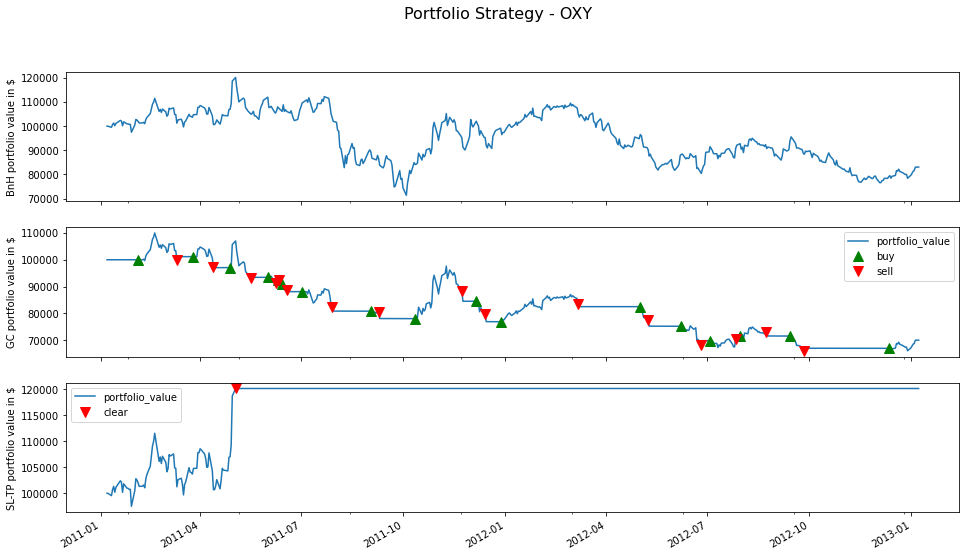

In [484]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=[16, 9])

# portfolio value
bnh_high[oxy].portfolio_value.plot(ax=ax[0])
ax[0].set_ylabel('BnH portfolio value in $')


# portfolio value
ma_high[oxy].portfolio_value.plot(ax=ax[1])
ax[1].set_ylabel('GC portfolio value in $')
buys = ma_high[oxy].loc[ma_high[oxy].buy==True]
sells = ma_high[oxy].loc[ma_high[oxy].sell==True]
ax[1].plot(buys.index, ma_high[oxy].portfolio_value.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax[1].plot(sells.index, ma_high[oxy].portfolio_value.loc[sells.index], 'v', markersize=10, color='r', label='sell')
ax[1].legend()

# portfolio value
sl_tp_high_10[oxy].portfolio_value.plot(ax=ax[2])
ax[2].set_ylabel('SL-TP portfolio value in $')
ax[2].plot(stop, sl_tp_high_10[oxy].portfolio_value.loc[stop], 'v', markersize=10, color='r', label='clear')

"""
# asset
buy_and_hold_results.price.plot(ax=ax[1])
ax[1].set_ylabel('price in $')

# mark transactions
perf_trans = buy_and_hold_results.loc[[t != [] for t in buy_and_hold_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax[1].plot(buys.index, buy_and_hold_results.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax[1].plot(sells.index, buy_and_hold_results.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')

# daily returns
buy_and_hold_results.returns.plot(ax=ax[2])
ax[2].set_ylabel('daily returns')
"""
fig.suptitle('Portfolio Strategy - OXY', fontsize=16)
plt.legend()
plt.show()

#print('Final portfolio value (including cash): {}$'.format(np.round(buy_and_hold_results.portfolio_value[-1], 2)))
